
# [TEST] - APIs


## 0. Configuración

In [ ]:
import sys
import os
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime


In [ ]:
sys.path.append('../scripts')

In [ ]:
# Configuración de estilo
plt.style.use('ggplot')
sns.set_palette("husl")

In [ ]:
from project_config import ProjectConfig as cfg

In [ ]:
lat = -39.422539
lon = -71.936493
bbox = "-41.993,-71.884,-41.031,-71.046"
start_date = "2024-12-01"
end_date = "2025-03-10"


## 1. APIs

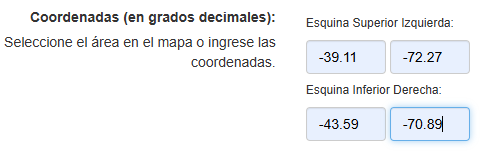


###  OpenMeteo

In [ ]:
from openmeteo_tools import OpenMeteoWeather

fetcher = OpenMeteoWeather()
df_clima = fetcher.obtener_clima(lat, lon, start_date, end_date, bbox)

# También guardar en data/processed
data_to_csv(df_clima, "open_meteo", f"OpenMeteo{start_date}_{end_date}_{datetime.datetime.now().strftime('%Y%m%d')}.csv")

# processed_dir = "../data/raw/open_meteo"
# os.makedirs(processed_dir, exist_ok=True)
# df_clima.to_csv(f"{processed_dir}/clima_procesado.csv", index=False)

print("✅ Datos obtenidos exitosamente!")
print("💾 Datos guardados exitosamente!")
print(f"📊 Dimensiones: {df_clima.shape}")
print(f"📋 Columnas: {list(df_clima.columns)}")

print("\n📅 Rango temporal:")
print(f"   Inicio: {df_clima['date'].min()}")
print(f"   Fin: {df_clima['date'].max()}")

print("\n🔍 Primeras filas:")
display(df_clima.head())

print("\n📈 Estadísticas descriptivas:")
display(df_clima.describe())

In [ ]:
if not df_clima.empty:
    # Copia + Filtro de Fecha
    df_isolated = df_clima.copy()
    df_isolated['date'] = pd.to_datetime(df_isolated['date'])
    df_isolated = df_isolated[df_isolated['date'] > pd.Timestamp('2025-03-09', tz='UTC')]

    fig, axes = plt.subplots(3, 2, figsize=(15, 12))

    # Temperatura
    df_isolated.plot(x='date', y='temperature_2m', ax=axes[0,0], title='Temperatura (°C)', color='red')
    axes[0,0].set_ylabel('Temperatura (°C)')
    
    # Humedad
    df_isolated.plot(x='date', y='relative_humidity_2m', ax=axes[0,1], title='Humedad Relativa (%)', color='blue')
    axes[0,1].set_ylabel('Humedad (%)')
    
    # Precipitación
    df_isolated.plot(x='date', y='precipitation', ax=axes[1,0], title='Precipitación (mm)', color='green')
    axes[1,0].set_ylabel('Precipitación (mm)')
    
    # Velocidad del viento
    df_isolated.plot(x='date', y='wind_speed_100m', ax=axes[1,1], title='Velocidad del Viento (km/h)', color='orange')
    axes[1,1].set_ylabel('Velocidad (km/h)')
    
    # Presión atmosférica
    df_isolated.plot(x='date', y='surface_pressure', ax=axes[2,0], title='Presión Atmosférica (hPa)', color='purple')
    axes[2,0].set_ylabel('Presión (hPa)')
    
    # # Cobertura de nubes
    # df_isolated.plot(x='date', y='cloud_cover', ax=axes[2,1], title='Cobertura de Nubes (%)', color='gray')
    # axes[2,1].set_ylabel('Cobertura (%)')
    
    plt.tight_layout()
    plt.show()

In [ ]:
print("📊 Resumen por día:")
df_daily = df_weather.groupby('date').agg({
    'temperature': ['mean', 'min', 'max'],
    'humidity': 'mean',
    'pressure': 'mean',
    'wind_speed': 'mean',
    'precipitation': 'sum',
    'rain': 'sum',
    'snowfall': 'sum',
    'sunshine_hours': 'sum'
}).round(2)

df_daily.columns = [
    'temp_promedio', 'temp_min', 'temp_max', 
    'humedad_promedio', 'presion_promedio', 
    'viento_promedio', 'precipitacion_total',
    'lluvia_total', 'nieve_total', 'horas_sol'
]

display(df_daily)

In [ ]:
print("🔗 Matriz de correlación:")
numeric_cols = ['temperature', 'humidity', 'pressure', 'wind_speed', 'precipitation']
corr_matrix = df_weather[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Matriz de Correlación - Variables Meteorológicas')
plt.tight_layout()
plt.savefig('../docs/correlacion_clima.png', dpi=300, bbox_inches='tight')
plt.show()


### Climate Data Store (CDS) - Copernicus

In [ ]:
from cds_tools import CDSTools

cds = CDSTools()

variables = [
    "2m_temperature",
    "2m_dewpoint_temperature",
    "total_precipitation",
    "surface_pressure",
    "10m_u_component_of_wind",
    "10m_v_component_of_wind"
]

# Obtener datos de temperatura
data = cds.download_data(
    start_date="2024-07-02",
    end_date="2024-07-02",
    latitude=-41.422539,
    longitude=-73.123123,
    dataset="reanalysis-era5-single-levels",
    variable="2m_temperature",
    radius=0.5,
)

# Transformar a DataFrame
df = xr.open_dataset(data).to_dataframe().reset_index()

# Convertir de Kelvin a Celsius
df['t2m'] = df['t2m'] - 273.15

# Guardado en directorio procesado
df.to_csv(f"{cfg.DATA_PROCESSED}/copernicus/Copernicus{start_date}_{end_date}_{datetime.datetime.now().strftime('%Y%m%d')}.csv", index=False)

In [ ]:
from copernicus_tools import CopernicusTools

copernicus = CopernicusTools(cfg)

file = copernicus.get_meteorological_data()

df_clima.to_csv(f"{processed_dir}/clima_procesado.csv", index=False)
print("Archivo descargado:", file)


### FIRMS - NASA

In [ ]:
from firms_tools import FIRMSTools
from project_config import ProjectConfig

# Inicializar herramientas
config = ProjectConfig()
firms = FIRMSTools(config)

# Descargar datos
print("Descargando datos de FIRMS...")
# raw_data = firms.download_fire_data(source='MODIS_SP')
raw_data = firms.get_multisource_fire_data()

# if raw_data is not None and not raw_data.empty:
#     print(f"✓ Datos descargados exitosamente: {len(raw_data)} registros")
#     print(f"Columnas: {list(raw_data.columns)}")
    
#     # Procesar datos
#     processed_data = firms.process_fire_data(raw_data)
#     print(f"Datos procesados: {len(processed_data)} registros")
    
#     # Mostrar información básica
#     print(f"\n📊 Resumen de datos:")
#     print(f"Rango temporal: {processed_data['acq_date'].min()} to {processed_data['acq_date'].max()}")
#     print(f"Número de días con datos: {processed_data['acq_date'].nunique()}")
    
#     if 'confidence' in processed_data.columns:
#         print(f"Distribución de confianza:")
#         print(processed_data['confidence'].value_counts())
    
#     # Visualización rápida
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
#     # Distribución temporal
#     daily_counts = processed_data['acq_date'].value_counts().sort_index()
#     daily_counts.plot(ax=ax1, kind='bar', title='Detecciones por día')
#     ax1.tick_params(axis='x', rotation=45)
    
#     # Mapa de detecciones
#     geometry = [Point(xy) for xy in zip(processed_data.longitude, processed_data.latitude)]
#     gdf = gpd.GeoDataFrame(processed_data, geometry=geometry, crs="EPSG:4326")
    
#     # Cargar mapa base de Argentina
#     world = gpd.read_file("https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip")
#     argentina = world[world.NAME == 'Argentina']
    
#     argentina.plot(ax=ax2, color='lightgray', edgecolor='black')
#     gdf.plot(ax=ax2, color='red', markersize=10, alpha=0.7, label='Detecciones')
#     ax2.set_title('Ubicación de detecciones de incendios')
#     ax2.legend()
    
#     plt.tight_layout()
#     plt.show()
# else:
#     print("❌ No se pudieron obtener datos. Revisa los logs para más detalles.")

In [ ]:
import logging
from spatial_analysis import SpatialAnalysis
from project_config import DATA_PROCESSED

# Configuración
logging.basicConfig(level=logging.INFO)
plt.style.use('ggplot')

# Cargar datos
print("📊 Cargando datos de incendios...")
fire_data = pd.read_csv('../data/raw/firms/firms_MODIS_SP_2024-12-20_2024-12-29.csv')

# Mostrar información básica
print(f"Total de detecciones: {len(fire_data)}")
print(f"Rango temporal: {fire_data['acq_date'].min()} to {fire_data['acq_date'].max()}")
print(f"Columnas disponibles: {list(fire_data.columns)}")

# Inicializar análisis espacial
print("\n🔍 Iniciando análisis espacial...")
spatial_analyzer = SpatialAnalysis(fire_data)

# 1. Crear GeoDataFrame
gdf = spatial_analyzer.create_geodataframe()
print(f"GeoDataFrame creado: {len(gdf)} features")

# 2. Calcular estadísticas básicas
stats = spatial_analyzer.calculate_basic_stats()
print("\n📈 Estadísticas espaciales:")
for key, value in stats.items():
    print(f"{key}: {value}")

# 3. Visualización estática
print("\n🎨 Generando visualizaciones...")
spatial_analyzer.plot_spatial_distribution(save_path = '../docs/Entregas/spatial_analysis.png')

# 4. Análisis de clusters
print("\n📊 Analizando clusters espaciales...")
cluster_stats = spatial_analyzer.cluster_analysis()
print("Estadísticas por cluster:")
print(cluster_stats)

# 5. Mapa interactivo (opcional - requiere folium)
try:
    print("\n🌍 Creando mapa interactivo...")
    interactive_map = spatial_analyzer.plot_interactive_map(save_path='../docs/Entregas/interactive_map.html')
    print("Mapa interactivo guardado como 'interactive_map.html'")
except ImportError:
    print("Folium no instalado. Instala con: pip install folium")

# 6. Exportar resultados
print("\n💾 Exportando resultados...")
spatial_analyzer.export_results(DATA_PROCESSED)
print("Análisis completado! ✅")

# Análisis adicional por día/noche
print("\n🌙 Análisis día vs noche:")
day_night_stats = gdf.groupby('daynight').agg({
    'frp': ['mean', 'sum', 'count'],
    'confidence': 'mean',
    'brightness': 'mean'
}).round(2)
print(day_night_stats)

# Análisis por satélite
print("\n🛰️ Análisis por satélite:")
satellite_stats = gdf.groupby('satellite').agg({
    'frp': ['mean', 'sum', 'count'],
    'confidence': 'mean'
}).round(2)
print(satellite_stats)